In [1]:
import sys
sys.path.append('../../../src')
import os
import pandas
import random
import math
from itertools import product
from functools import reduce
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport, VaryingTransport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from pyomo.environ import value as pyoval
from energiapy.utils.scale_utils import scale_pyomo_set, scale_tuple, scale_list, scale_changer
import matplotlib.pyplot as plt
from matplotlib import rc
from typing import Union, Tuple, List
from pyomo.environ import ConcreteModel, Var, Constraint, NonNegativeReals
from pyomo.contrib.iis import write_iis
import time
import pickle
from energiapy.model.constraints.constraints import make_constraint, Cons
from energiapy.model.formulate import constraint_export

import mpisppy.utils.sputils as sputils
from mpisppy.opt.ef import ExtensiveForm
import networkx as nx

[    0.00] Initializing mpi-sppy


In [2]:
_coms = 1

design_planning_horizons = 1
design_exec_scenarios = 4
design_scale_factor = 13*7

schedule_planning_horizons = 1
schedule_exec_scenarios = 52
schedule_time_intervals = 7

M = 1e4  # Big M

design_annualization_factor = 1/design_planning_horizons
schedule_annualization_factor = 1/schedule_planning_horizons

In [3]:
def create_list(n_total: int, n: int):
    return [1] * n + [0] * (n_total - n)

In [4]:
def sum_probabilities(d:dict):
    total_prob = 0

    def recursive_sum(current_dict:dict):
        nonlocal total_prob
        for key, value in current_dict.items():
            if isinstance(value, dict):
                # Recursively traverse if it's still a dictionary
                recursive_sum(value)
            elif key == 'prob':
                # Add the probability value
                total_prob += value

    recursive_sum(d)
    return total_prob

In [5]:
def create_event_dict(n_total: int):
    default_list = [1] * n_total

    # If event names are same before '_'; they are considered mutually exclusive else the events are treated as independent
    event_dict = {
        'cap2_1': {'prob': 0.06, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 1)})},
        'cap2_2': {'prob': 0.12, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 2)})},
        'cap2_3': {'prob': 0.17, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 3)})},
        # 'cap2_1': {'prob': 0.35, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 1)})},
        'cap2_nd': {'prob': 0.65, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): default_list})},

        'cap4_1': {'prob': 0.05, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 1)})},
        'cap4_2': {'prob': 0.15, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 2)})},
        'cap4_3': {'prob': 0.18, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 3)})},
        # 'cap4_2': {'prob': 0.38, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 2)})},
        'cap4_nd': {'prob': 0.62, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): default_list})},

        'res6_1': {'prob': 0.03, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 1)})},
        'res6_2': {'prob': 0.16, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 2)})},
        'res6_3': {'prob': 0.17, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 3)})},
        # 'res6_3': {'prob': 0.36, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 3)})},
        'res6_nd': {'prob': 0.64, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): default_list})},

        # 'truck25_1': {'prob': 0.03, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 1)})},
        # 'truck25_2': {'prob': 0.2, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 2)})},
        # 'truck25_3': {'prob': 0.05, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): create_list(n_total, 2)})},
        # 'truck25_nd': {'prob': 0.72, 'factor': pandas.DataFrame(data={('truck25', 'com1_loc2_out'): default_list})},
        # 
        # 'truck47_1': {'prob': 0.04, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 1)})},
        # 'truck47_2': {'prob': 0.085, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 2)})},
        # 'truck47_3': {'prob': 0.075, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): create_list(n_total, 3)})},
        # 'truck47_nd': {'prob': 0.80, 'factor': pandas.DataFrame(data={('truck47', 'com1_loc4_out'): default_list})}
    }

    return event_dict

In [6]:
# Function to generate the scenario dictionary for n sets of events
def create_scenario_dict(event_dict):
    # Extract unique event prefixes (e.g., 'cap2', 'cap4', ...)
    event_prefixes = set(key.split('_')[0] for key in event_dict)

    # Group events by their prefixes
    grouped_events = {prefix: [key for key in event_dict if key.startswith(prefix)] for prefix in event_prefixes}

    # Create all possible combinations of events across the different groups
    event_combinations = list(product(*grouped_events.values()))

    scenario_dict = {}

    # Iterate over all event combinations
    for combination in event_combinations:
        # Construct the scenario key
        scenario_key = ' '.join(combination)

        # Calculate the probability of this scenario
        prob = 1
        combined_factor = None

        for event_key in combination:
            # Multiply probabilities
            prob *= event_dict[event_key]['prob']

            # Combine factors (assumes they are pandas DataFrames)
            if combined_factor is None:
                combined_factor = event_dict[event_key]['factor'].copy()
            else:
                combined_factor = combined_factor.add(event_dict[event_key]['factor'], fill_value=0)

        # Add to the scenario dictionary
        scenario_dict[scenario_key] = {'prob': prob, 'factor': combined_factor}

    return scenario_dict

In [7]:
def build_design_model(scen_df=pandas.DataFrame()):
    default_df = pandas.DataFrame(data=[1] * design_exec_scenarios)
    
    # Define temporal scales
    scales = TemporalScale(discretization_list=[design_planning_horizons, design_exec_scenarios])
    
    # ======================================================================================================================
    # Declare resources/commodities
    # ======================================================================================================================
    com1_pur = Resource(name='com1_pur', cons_max=75*design_scale_factor, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])
    
    com1_in = Resource(name='com1_in', label='Commodity 1 received')
    com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')
    
    com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
    com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
    com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
    com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
    com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
    com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
    com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')
    
    com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')
    
    # ======================================================================================================================
    # Declare processes/storage capacities
    # ======================================================================================================================
    com1_process_capacity = 150*design_scale_factor
    min_process_capacity = 0.01
    
    com1_procure = Process(name='procure com1', prod_max=com1_process_capacity, conversion={com1_pur: -1, com1_in: 1}, capex=0.1/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Procure com1')
    com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Sell com1')
    
    com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 1')
    com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 2')
    com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 3')
    com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 4')
    com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 5')
    com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 6')
    com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Commodity 1 received from location 7')
    
    com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},  capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')
    
    com1_store = Process(name='com1_store', prod_max=com1_process_capacity, capex=0.01/design_scale_factor, vopex=5, store_min=0.01, store_max= 100*design_scale_factor, prod_min=min_process_capacity, label="Storage capacity of upto 100 units", storage=com1_in, storage_cost=0.02, storage_capex=50/design_scale_factor)
    
    com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 1')
    com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 2')
    com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 3')
    com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 4')
    com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 5')
    com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 6')
    com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.01/design_scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Send commodity one from location 7')
    
    # ======================================================================================================================
    # Declare locations/warehouses
    # ======================================================================================================================
    loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc1', 'com1_pur')]] if ('loc1', 'com1_pur') in scen_df else default_df})
    
    loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc2', 'com1_process')]] if ('loc2', 'com1_process') in scen_df else default_df})
    
    loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1)
    
    loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc4', 'com1_process')]] if ('loc4', 'com1_process') in scen_df else default_df})
    
    loc5 = Location(name='loc5', processes={com1_receive_loc1, com1_receive_loc2, com1_receive_loc4, com1_receive_loc6, com1_receive_loc7, com1_process, com1_store, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1)
    
    loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, availability_factor={
                        com1_pur: scen_df[[('loc6', 'com1_pur')]] if ('loc6', 'com1_pur') in scen_df else default_df})
    
    loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1, capacity_factor={
        com1_process: scen_df[[('loc7', 'com1_process')]] if ('loc7', 'com1_process') in scen_df else default_df})
    
    # ======================================================================================================================
    # Declare transport/trucks
    # ======================================================================================================================
    
    truck_cap12 = 70 * design_scale_factor
    truck_cap13 = 30 * design_scale_factor
    truck_cap24 = 50 * design_scale_factor
    truck_cap25 = 30 * design_scale_factor
    truck_cap34 = 30 * design_scale_factor
    truck_cap45 = 100 * design_scale_factor
    truck_cap47 = 40 * design_scale_factor
    truck_cap64 = 50 * design_scale_factor
    truck_cap75 = 40 * design_scale_factor
    
    plane_cap15 = 50 * design_scale_factor
    plane_cap65 = 50 * design_scale_factor
    
    truck_capmin = 0.01
    plane_capmin = 0.01
    
    truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12, label='Truck from location 1 to 2', capex=0.5/design_scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13, label='Truck from location 1 to 3', capex=0.3/design_scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24, label='Truck from location 2 to 4', capex=0.5/design_scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25, label='Truck from location 2 to 5', capex=0.3/design_scale_factor, vopex=0.03, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34, label='Truck from location 3 to 4', capex=0.2/design_scale_factor, vopex=0.02, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45, label='Truck from location 4 to 5', capex=1/design_scale_factor, vopex=0.1, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47, label='Truck from location 4 to 7', capex=0.4/design_scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64, label='Truck from location 6 to 4', capex=0.5/design_scale_factor, vopex=0.05, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75, label='Truck from location 7 to 5', capex=0.4/design_scale_factor, vopex=0.04, trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    plane15 = Transport(name='plane15', resources={com1_loc1_out}, trans_max=plane_cap15, label='Plane from location 1 to 5', capex=1/design_scale_factor, vopex=0.5,
                        trans_min=plane_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    plane65 = Transport(name='plane65', resources={com1_loc6_out}, trans_max=plane_cap65, label='Plane from location 6 to 5', capex=1/design_scale_factor, vopex=0.5,
                        trans_min=plane_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    
    # ======================================================================================================================
    # Declare network
    # ======================================================================================================================

    transport_matrix = [
        [[], [truck12], [truck13], [], [plane15], [], []],  # source: location 1
        [[], [], [], [truck24], [truck25], [], []],  # source: location 2
        [[], [], [], [truck34], [], [], []],  # source: location 3
        [[], [], [], [], [truck45], [], [truck47]],  # source: location 4
        [[], [], [], [], [], [], []],  # source: location 5
        [[], [], [], [truck64], [plane65], [], []],  # source: location 6
        [[], [], [], [], [truck75], [], []]  # source: location 7
    ]

    # transport_matrix = [
    #     [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    #     [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    #     [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    #     [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    #     [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    #     [[], [], [], [truck64], [], [], []],  # source: location 6
    #     [[], [], [], [truck74], [truck75], [], []]  # source: location 7
    # ]

    distance_matrix = [
        [0, 55, 196, M, 130, M, M],
        [55, 0, M, 163, 112, M, 134],
        [196, M, 0, 63, M, M, M],
        [M, 163, 63, 0, 95, 117, 88],
        [130, 112, M, 95, 0, 150, 134],
        [M, M, M, 117, 150, 0, M],
        [M, 134, M, 88, 134, M, 0]
    ]

    locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

    sources = locset
    sinks = locset

    network = Network(name='Network', scales=scales, source_locations=sources, sink_locations=sinks,
                      transport_matrix=transport_matrix, distance_matrix=distance_matrix, transport_capacity_scale_level=1,
                      transport_capacity_factor={(loc1, loc2): {truck12: scen_df[[('truck12', 'com1_loc1_out')]] if ('truck12', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc1, loc3): {truck13: scen_df[[('truck13', 'com1_loc1_out')]] if ('truck13', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc1, loc5): {plane15: scen_df[[('plane15', 'com1_loc1_out')]] if ('plane15', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc2, loc4): {truck24: scen_df[[('truck24', 'com1_loc2_out')]] if ('truck24', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc2, loc5): {truck25: scen_df[[('truck25', 'com1_loc2_out')]] if ('truck25', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc3, loc4): {truck34: scen_df[[('truck34', 'com1_loc3_out')]] if ('truck34', 'com1_loc3_out') in scen_df else default_df},
                                                 (loc4, loc5): {truck45: scen_df[[('truck45', 'com1_loc4_out')]] if ('truck45', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc4, loc7): {truck47: scen_df[[('truck47', 'com1_loc4_out')]] if ('truck47', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc6, loc4): {truck64: scen_df[[('truck64', 'com1_loc6_out')]] if ('truck64', 'com1_loc6_out') in scen_df else default_df},
                                                 (loc6, loc5): {plane65: scen_df[[('plane65', 'com1_loc6_out')]] if ('plane65', 'com1_loc6_out') in scen_df else default_df},
                                                 (loc7, loc5): {truck75: scen_df[[('truck75', 'com1_loc7_out')]] if ('truck75', 'com1_loc7_out') in scen_df else default_df},
                                                 })
    
    # ======================================================================================================================
    # Declare scenario
    # ======================================================================================================================
    
    daily_demand = 100*design_scale_factor
    demand_penalty = 500
    
    demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
    demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}
    
    scenario = Scenario(name=f'design scenario', scales=scales, scheduling_scale_level=1, network_scale_level=0, purchase_scale_level=1, availability_scale_level=1, demand_scale_level=1, capacity_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Design Scenario', annualization_factor=design_annualization_factor)
    
    if scen_df.empty:
        # ======================================================================================================================
        # Declare problem
        # ======================================================================================================================

        problem_mincost = formulate(scenario=scenario,
                                    constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                                 Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                                 Constraints.NETWORK},
                                    demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

        scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
        # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
        # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)
        
        problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')
        
        def first_stage_cost_rule(instance):
            return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) + 
                                                sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))
        
        problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)
        
        return scenario, problem_mincost
    else:
        return scenario

In [8]:
def build_design_smodel(scen_df=pandas.DataFrame()):
    scenario = build_design_model(scen_df)
    # ======================================================================================================================
    # Declare problem
    # ======================================================================================================================

    problem_mincost = formulate(scenario=scenario,
                                constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                             Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                             Constraints.NETWORK},
                                demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

    scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
    # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
    # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)

    problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')

    def first_stage_cost_rule(instance):
        return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) +
                sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))

    problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)

    return scenario, problem_mincost

In [9]:
def design_scenario_creator(scen_name, **kwargs):
    scen_dict = kwargs.get('scenario_dict')
    scen, model = build_design_smodel(scen_df=scen_dict[scen_name]['factor'])
    sputils.attach_root_node(model, model.first_stage_cost,
                             [model.X_P, model.Cap_P, model.X_S, model.Cap_S, model.X_F, model.Cap_F])
    model._mpisppy_probability = scen_dict[scen_name]['prob']
    return model

In [10]:
options = {"solver": "gurobi"}
solver_options = {
    'MIPGap': 0.005,
    'Heuristics': 0.20
}

In [11]:
event_dict = create_event_dict(n_total=design_exec_scenarios)
scenario_dict = create_scenario_dict(event_dict=event_dict)
scenario_names = list(scenario_dict.keys())

with open('scenario_dict_HP.pkl', 'wb') as file:
    pickle.dump(scenario_dict, file)

# print(*scenario_names, sep='\n')
print(f"Sum of probabilities of all scenarios: {sum(scenario_dict[scen]['prob'] for scen in scenario_dict):.6f}")
print(f'Number of considered scenarios: {len(scenario_names)}')

Sum of probabilities of all scenarios: 1.000000
Number of considered scenarios: 64


In [12]:
with open('scenario_dict_HP.pkl', 'rb') as file:
    load_scenario_dict = pickle.load(file)

load_scenario_names = list(load_scenario_dict.keys())

print(f"Sum of probabilities of all scenarios: {sum(load_scenario_dict[scen]['prob'] for scen in load_scenario_dict):.6f}")
print(f'Number of considered scenarios: {len(load_scenario_names)}')

Sum of probabilities of all scenarios: 1.000000
Number of considered scenarios: 64


In [13]:
PI_pkl_folder = r'PI_HP_pkl'
FD_pkl_folder = r'FD_HP_pkl'

In [14]:
exCost_PI = 0
results_PI = dict()
scen_PI, model_PI = build_design_model()

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint transport capacity UB
constraint transport capacity LB
constraint demand penalty
constraint demand penalty location
constraint deman

In [15]:
# Deterministic Scenarios for Perfect Information
counter = 0
PI_output_dict=dict()

for scen_name in load_scenario_names:
    scen_PI = build_design_model(scen_df=load_scenario_dict[scen_name]['factor'])
    counter+=1
    # Delete process capacity factors, resource availability factors, transport capacity factors
    model_PI.del_component('constraint_nameplate_production_varying_capacity')
    model_PI.del_component('constraint_resource_consumption_varying')
    model_PI.del_component('constraint_export')

    # Add the constraints back for this particular scenario
    model_PI.constraint_nameplate_production_varying_capacity = make_constraint(instance=model_PI,
        type_cons=Cons.X_LEQ_BY, variable_x='P', location_set=model_PI.locations, component_set=model_PI.processes_varying_capacity,
        loc_comp_dict=scen_PI.location_process_dict, b_factor=scen_PI.capacity_factor,
                                                                                x_scale_level=scen_PI.scheduling_scale_level,
                                                                                b_scale_level=scen_PI.capacity_scale_level,
                                                                                y_scale_level=scen_PI.network_scale_level,
                                                                                variable_y='Cap_P',
                                                                                label='restricts production to varying nameplate capacity')

    model_PI.constraint_resource_consumption_varying = make_constraint(
        instance=model_PI, type_cons=Cons.X_LEQ_B, variable_x='C', location_set=model_PI.locations,
        component_set=model_PI.resources_varying_availability, b_max=scen_PI.cons_max,
        loc_comp_dict=scen_PI.location_resource_dict, b_factor=scen_PI.availability_factor,
        x_scale_level=scen_PI.scheduling_scale_level, b_scale_level=scen_PI.availability_scale_level,
        label='restricts resource consumption to varying availablity')

    constraint_export(instance=model_PI, scheduling_scale_level=scen_PI.scheduling_scale_level,
                      network_scale_level=scen_PI.network_scale_level,
                      location_transport_resource_dict=scen_PI.location_transport_resource_dict,
                      transport_capacity_factor=scen_PI.transport_capacity_factor,
                      transport_capacity_scale_level=scen_PI.transport_capacity_scale_level)

    results_PI[scen_name] = solve(scenario=scen_PI, instance=model_PI, solver='gurobi', name=scen_name,
                       solver_options=solver_options)

    print(f'######################## Finished solving {scen_name} ({counter} of {len(load_scenario_names)}) ########################')

    model_vars = model_PI.component_map(ctype=Var)
    vars_dict = {i: model_vars[i].extract_values() for i in model_vars.keys()}
    obj_dict = {'objective': pyoval(model_PI.objective_cost_w_demand_penalty)}

    PI_output_dict[scen_name] = {**vars_dict, **obj_dict}

    with open(fr"{PI_pkl_folder}\{scen_name}_{len(load_scenario_names)}.pkl", 'wb') as file:
        pickle.dump(PI_output_dict[scen_name], file)

    exCost_PI += pyoval(model_PI.objective_cost_w_demand_penalty) * load_scenario_dict[scen_name]['prob']

constraint export
Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter Heuristics to value 0.2
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
MIPGap  0.005
Heuristics  0.2
QCPDual  1

Optimize a model with 11143 rows, 21851 columns and 15811 nonzeros
Model fingerprint: 0xa39d3f96
Variable types: 21172 continuous, 679 integer (679 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+04]
  Objective range  [1e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+03, 1e+04]
Presolve removed 10899 rows and 21680 columns
Presolve time: 0.01s
Presolved: 244 rows, 171 columns, 606 nonzeros
Variable types: 123 continuous, 48 integer (48 binary)
Found heuristic solution: objective 1.820000e

In [16]:
print(f"Total Expected Cost considering perfect information: {exCost_PI:.4f}")

Total Expected Cost considering perfect information: 716793.0792


In [17]:
for scen_name in load_scenario_names:
    print(fr"Demand penalty cost of network for {scen_name}: {PI_output_dict[scen_name]['Demand_penalty_cost_network']}")

Demand penalty cost of network for res6_1 cap2_1 cap4_1: {('com1_sold', 0): 4550000.0}
Demand penalty cost of network for res6_1 cap2_1 cap4_2: {('com1_sold', 0): 3412500.0}
Demand penalty cost of network for res6_1 cap2_1 cap4_3: {('com1_sold', 0): 2275000.0}
Demand penalty cost of network for res6_1 cap2_1 cap4_nd: {('com1_sold', 0): 1137500.0}
Demand penalty cost of network for res6_1 cap2_2 cap4_1: {('com1_sold', 0): 3412500.0}
Demand penalty cost of network for res6_1 cap2_2 cap4_2: {('com1_sold', 0): 3412500.0}
Demand penalty cost of network for res6_1 cap2_2 cap4_3: {('com1_sold', 0): 2275000.0}
Demand penalty cost of network for res6_1 cap2_2 cap4_nd: {('com1_sold', 0): 1137500.0}
Demand penalty cost of network for res6_1 cap2_3 cap4_1: {('com1_sold', 0): 2275000.0}
Demand penalty cost of network for res6_1 cap2_3 cap4_2: {('com1_sold', 0): 2275000.0}
Demand penalty cost of network for res6_1 cap2_3 cap4_3: {('com1_sold', 0): 2275000.0}
Demand penalty cost of network for res6_1

In [18]:
with open(fr"{PI_pkl_folder}\exCost_{len(load_scenario_names)}_PI_HP.pkl", 'wb') as file:
    pickle.dump(exCost_PI, file)

with open(fr"{PI_pkl_folder}\exCost_{len(load_scenario_names)}_PI_HP.pkl", 'rb') as file:
    exCost_PI_load = pickle.load(file)

In [19]:
exCost_PI_load

716793.0792394737

In [20]:
load_PI_dict = dict()
for file in os.listdir(PI_pkl_folder):
    if file.endswith('.pkl') and not file.endswith('_HP.pkl'):
        full_file_path = os.path.join(PI_pkl_folder, file)
        
        with open(full_file_path, 'rb') as f:
            load_PI_dict[file.removesuffix(f'_{len(load_scenario_names)}.pkl')] = pickle.load(f)
            
# len(PI_load_dict)

In [21]:
def find_common_substring(lst):
    
    # Split each string into substrings and create sets
    substring_sets = [set(item.split()) for item in lst]
    
    # Find the intersection of all sets to get common substrings
    common_substrings = reduce(lambda a, b: a & b, substring_sets)
    
    return common_substrings

In [22]:
def explore_dict(d, level=0):
    indent = "    " * level  # Indentation for better readability
    for key, value in d.items():
        print(f"{indent}Key: {key}, Type of value: {type(value)}")
        if isinstance(value, dict):  # Recursively explore dictionaries
            explore_dict(value, level + 1)

In [23]:
def filter_scenarios():
    # Initialize the result dictionary
    result = {}
    
    # Step 1: Iterate over the original data
    for scenario, data in load_PI_dict.items():
        x_val = data['Demand_penalty_network'][('com1_sold',0)]
        obj_val = data['objective'] - data['Demand_penalty_network'][('com1_sold',0)]
        
        # Step 2: Check if x_val is already a key in the result
        if x_val not in result:
            result[x_val] = {'count': 0, 'objectives': {}}
        
        # Increment the count for the x value
        result[x_val]['count'] += 1
        
        # Step 3: Check if obj_val is already a key under the 'objectives' for this x
        if obj_val not in result[x_val]['objectives']:
            result[x_val]['objectives'][obj_val] = {'scenarios': [], 'count': 0}
        
        # Add the scenario to the list and increment the count for the objective
        result[x_val]['objectives'][obj_val]['scenarios'].append(scenario)
        result[x_val]['objectives'][obj_val]['count'] += 1
    
    # Step 4: Sort the result by x values (in decreasing order) and objectives (in decreasing order)
    sorted_result = {
        x_val: {
            'count': result[x_val]['count'],
            'count_obj': len(result[x_val]['objectives']),
            'objectives': {
                obj_val: result[x_val]['objectives'][obj_val]
                for obj_val in sorted(result[x_val]['objectives'].keys(), reverse=True)
            }
        }
        for x_val in sorted(result.keys(), reverse=True)
    }
    
    return sorted_result

In [24]:
def pick_scenario_with_highest_probability(scenario_list, scenario_dict):
    # Filter scenarios in the list that are present in the dictionary
    valid_scenarios = [(s, scenario_dict[s]['prob']) for s in scenario_list if s in scenario_dict]

    # Find the maximum probability among valid scenarios
    max_prob = max(valid_scenarios, key=lambda x: x[1], default=(None, -1))[1]

    # Collect scenarios with the maximum probability
    highest_prob_scenarios = [s for s, p in valid_scenarios if p == max_prob]

    return random.choice(highest_prob_scenarios) if highest_prob_scenarios else None

In [25]:
def pick_scenarios(sorted_dict, n):
    selected_scenarios = {}
    total_selected = 0

    # Iterate over sorted x values
    for x_val, x_data in sorted_dict.items():
        if total_selected >= n:
            break  # Stop if we have selected enough scenarios

        # Iterate over sorted objective values within each x
        for obj_val, obj_data in x_data['objectives'].items():
            if total_selected >= n:
                break  # Stop if we have selected enough scenarios

            # Get the list of scenarios for the current objective
            scenarios_to_choose = obj_data['scenarios']

            # Choose the scenario with the highest probability using the previous logic
            chosen_scenario = pick_scenario_with_highest_probability(scenarios_to_choose, load_scenario_dict)

            # Add the selected scenario to the result
            if chosen_scenario:
                if x_val not in selected_scenarios:
                    selected_scenarios[x_val] = {}

                if obj_val not in selected_scenarios[x_val]:
                    selected_scenarios[x_val][obj_val] = {}

                selected_scenarios[x_val][obj_val][chosen_scenario] = {
                    'prob': load_scenario_dict[chosen_scenario]['prob'],
                    'factor': load_scenario_dict[chosen_scenario]['factor'].copy()
                }
                total_selected += 1

            if total_selected >= n:
                break  # Stop if we have selected enough scenarios

    return selected_scenarios


In [26]:
def sum_probabilities(d):
    total_prob = 0
    
    def recursive_sum(current_dict):
        nonlocal total_prob
        for key, value in current_dict.items():
            if isinstance(value, dict):
                # Recursively traverse if it's still a dictionary
                recursive_sum(value)
            elif key == 'prob':
                # Add the probability value
                total_prob += value

    recursive_sum(d)
    return total_prob

In [27]:
sorted_result = filter_scenarios()

with open(fr"sorted_result_{len(load_scenario_names)}_HP.pkl", 'wb') as file:
    pickle.dump(sorted_result, file)

In [28]:
with open(fr"sorted_result_{len(load_scenario_names)}_HP.pkl", 'rb') as file:
    load_sorted_result = pickle.load(file)

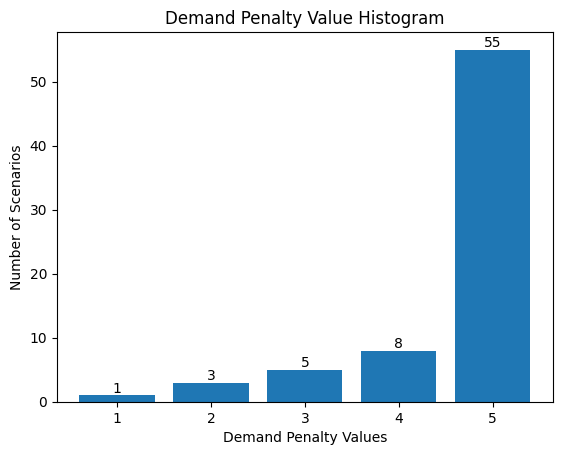

In [29]:
# Example data
n = len(list(load_sorted_result.keys()))
list1 = [i for i in range(1,n+1)]  # X-axis labels
list2 = [load_sorted_result[key]['count'] for key, data in load_sorted_result.items()]

# Create a bar chart
plt.bar(list1, list2)

# Add labels and title
plt.xlabel('Demand Penalty Values')
plt.ylabel('Number of Scenarios')
plt.title('Demand Penalty Value Histogram')

for i, value in enumerate(list2):
    plt.text(i+1, value, str(value), ha='center', va='bottom')

# Rotate the x-axis labels if they are too long or overlapping
plt.xticks()

# Show the plot
plt.show()

In [45]:
list(load_sorted_result.keys())

[9100.0, 6825.0, 4550.0, 2275.0, 0.0]

In [30]:
sum(data['count_obj'] for key, data in load_sorted_result.items())

58

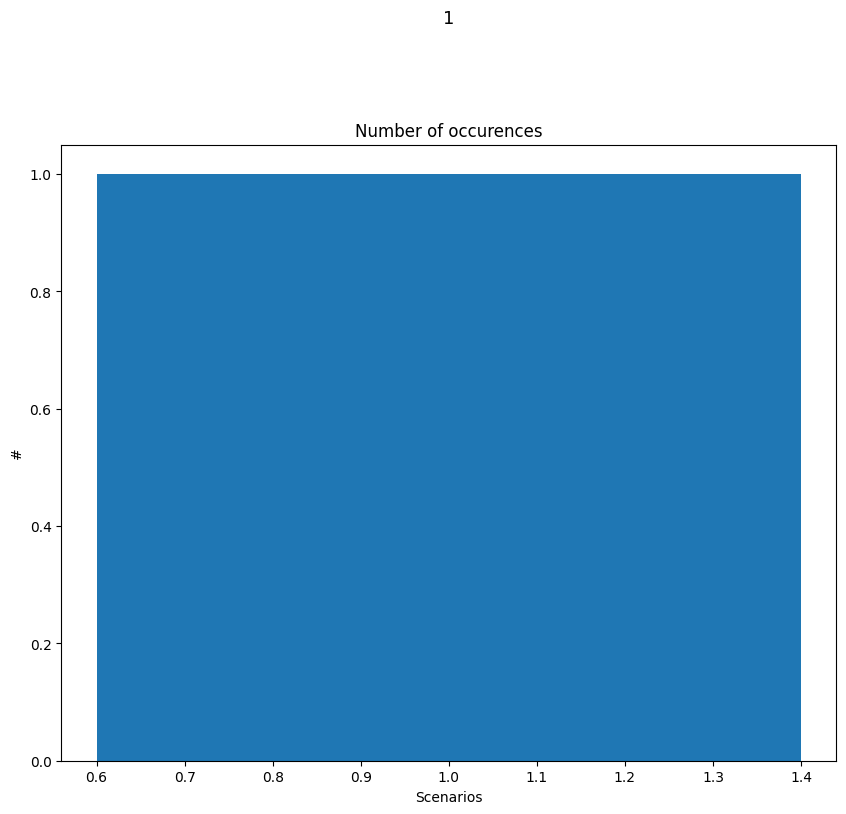

In [44]:
penalty_key = list(load_sorted_result.keys())[0]
n = min(load_sorted_result[penalty_key]['count_obj'], 10)
obj_keys = [list(load_sorted_result[penalty_key]['objectives'].keys())[i] for i in range(n)]
list1 = [i for i in range(1,n+1)]  # X-axis labels
list2 = [load_sorted_result[penalty_key]['objectives'][obj_keys[i]]['count'] for i in range(n)]

plt.figure(figsize=(10,8))

# Create a bar chart
plt.bar(list1, list2)

# Add labels and title
plt.xlabel('Scenarios')
plt.ylabel('#')
plt.title('Number of occurences')

for i, value in enumerate(list2):
    plt.text(i+1, value+0.25, str(value), ha='center', va='bottom', fontsize=13)

# Rotate the x-axis labels if they are too long or overlapping
# plt.xticks(rotation=45)

# Show the plot
plt.show()

In [34]:
penalty_key

9100.0